In [88]:
#import ROOT
import uproot
import matplotlib.pyplot as plt
import scipy as scp
from scipy.integrate import trapezoid
import numpy as np
import awkward as ak
from lmfit.models import GaussianModel

In [7]:
#Open root file with both shapes and measurements

FILE_PATH = "../Dati/Run_Na_waveform_maggio_1.root" #Relative file path
file = uproot.open(FILE_PATH)
file["tree"].show() #Display contents

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
ev                   | int32_t                  | AsDtype('>i4')
nch                  | int32_t                  | AsDtype('>i4')
ch                   | int32_t[]                | AsJagged(AsDtype('>i4'))
base                 | float[]                  | AsJagged(AsDtype('>f4'))
amp                  | float[]                  | AsJagged(AsDtype('>f4'))
charge               | float[]                  | AsJagged(AsDtype('>f4'))
letime               | float[]                  | AsJagged(AsDtype('>f4'))
tetime               | float[]                  | AsJagged(AsDtype('>f4'))
ratecount            | float[]                  | AsJagged(AsDtype('>f4'))
pshape               | float[][1024]            | AsJagged(AsDtype("('>f4', (...


In [8]:
print(type(file["tree"]["base"].array()))
bl=file["tree"]["base"].array()
print(ak.num(bl))
bl = bl[:-1]
print(np.unique(ak.num(bl)))
#l'ultimo array aveva una forma diversa, quindi l'ho tagliato altrimenti faceva casini

<class 'awkward.highlevel.Array'>
[16, 16, 16, 16, 16, 16, 16, 16, 16, ..., 16, 16, 16, 16, 16, 16, 16, 16, 10]
[16]


In [9]:
nch=file["tree"]["ch"].array()[:-1]
print(nch)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], ..., [0, 1, ..., 15]]


In [14]:
#Load data to numpy arrays

baselines = np.array(file["tree"]["base"].array()[1:-1]) #il [:-1] toglie l'ultimo evento che si è splittato male
charges = np.array(file["tree"]["charge"].array()[1:-1])
amp = np.array(file["tree"]["amp"].array()[1:-1])
lead_edge = np.array(file["tree"]["letime"].array()[1:-1])
channel= np.array(file["tree"]["ch"].array()[1:-1])
waveform = np.array(file["tree"]["pshape"].array()[1:-1])
t_edge=np.array(file["tree"]["tetime"].array()[1:-1])

(16971, 16, 1024)
channel: 0 baseline: 3.8e-05 charge -10.37 lead_edge 2476.186 trailing_edge 2478.703
channel: 1 baseline: 0.000724 charge -720.807 lead_edge 2458.952 trailing_edge 2460.721
channel: 2 baseline: 0.001182 charge -25.041 lead_edge 331.253 trailing_edge 333.402
channel: 3 baseline: 0.000686 charge -19.306 lead_edge 834.283 trailing_edge 836.065
channel: 4 baseline: 0.000572 charge -728.554 lead_edge 121.803 trailing_edge 123.486
channel: 5 baseline: 0.000991 charge -2.165 lead_edge 2377.728 trailing_edge 2381.706
channel: 6 baseline: 0.000191 charge -13.085 lead_edge 482.66 trailing_edge 486.177
channel: 7 baseline: 0.000343 charge -16.287 lead_edge 476.519 trailing_edge 478.568
channel: 8 baseline: 0.000686 charge -42.029 lead_edge 126.273 trailing_edge 129.915
channel: 9 baseline: 0.000381 charge -20.496 lead_edge 696.481 trailing_edge 699.631
channel: 10 baseline: -0.004308 charge -8.144 lead_edge 384.041 trailing_edge 386.28
channel: 11 baseline: 0.000114 charge -5.39

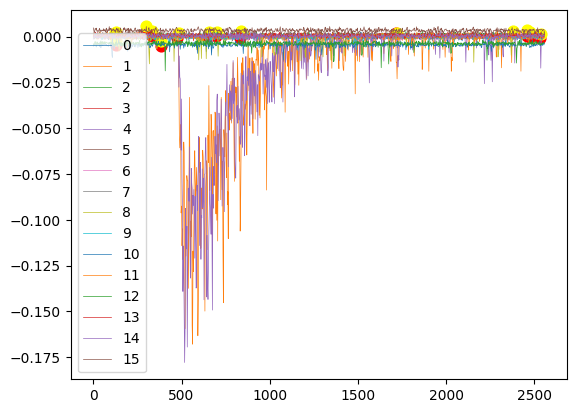

In [39]:
print(waveform.shape)
event= 960
list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
#list=[2, 9]
sampling=2.5
for channel in list:
    time=np.arange(1024)
    plt.plot(time*sampling, waveform[event][channel], label='{}'.format(channel), linewidth=0.5)
    print("channel:", channel, "baseline:",  baselines[event][channel],"charge", charges[event][channel], "lead_edge", lead_edge[event][channel], "trailing_edge", t_edge[event][channel] )
    t1=lead_edge[event][channel]
    t2=t_edge[event][channel]
    plt.scatter( t1, waveform[event][channel][int(t1/sampling)],s=60, color='red'  )
    plt.scatter( t2, waveform[event][channel][int(t2/sampling)],s=60, color='yellow'  )

plt.legend()

In [ ]:
canale=[0,1,2,3,4,5,8,9,12,13,14,15]
#l'ultimo è il 15
carica_gamma=[-492.991122,-869.542194, -755.683667, -1125.16284, -1223.87088, -1268.36734, -879.024502, -440.515158, -706.002694,
              -734.448274, -1088.07980, -1595.94856]
sigma_gamma=[55.3238139,60.6593683, 68.7226953, 89.3657356,  82.0439831, 97.4454060,  131.835623, 34.3645975, 122.979607,
             72.0804643, 79.5176462 ,95.8597859]

## Charge for each channel

In [41]:
np.arange(1,5, step=1)

array([1, 2, 3, 4])

In [55]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values


def rebin(data, factor):
    if len(data) % factor != 0:
        raise ValueError("Length of data must be divisible by factor.")
    rebinned_data = np.sum(data.reshape(-1, factor), axis=1)
    return rebinned_data
#PATH_MARTI="../Dati/Run_chall_ChargeHistos_4_12_2024_10M.dat"
PATH_SAM="../Dati/Run_Na_ChargeHistos_5_7_2024.dat"
edge_N, bin_N = load_histo(PATH_SAM)



channel_idx = np.arange(0,16, step=1)




In [251]:
channel=14 #no 10, 11, 6, 7
edge_N, bin_N = load_histo(PATH_SAM)
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2
bin_N = rebin(bin_N, rebin_fact)
tmp = []

for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [254]:
lim_list = [[-575, -430],  #ch0
            [-950, -800],      #ch1
            [-850, -700],  #ch2
            [-1200, -1000],  #ch3
            [-1350, -1105],  #ch4
            [-1350, -1155],  #ch5
            [-1700, -1400],  #ch6
            [-500, -180],  #ch7
            [-1100, -800],  #ch8
            [-500, -400],  #ch9
            [-600, -130],  #ch10
            [-600, -165],  #ch11
            [-850, -600],      #ch12
            [-800, -650],      #ch13
            [-1200, -1000],  #ch14
            [-1700, -1500]   #ch15
            ]


lim_N = lim_list[channel]
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

Text(0, 0.5, 'counts')

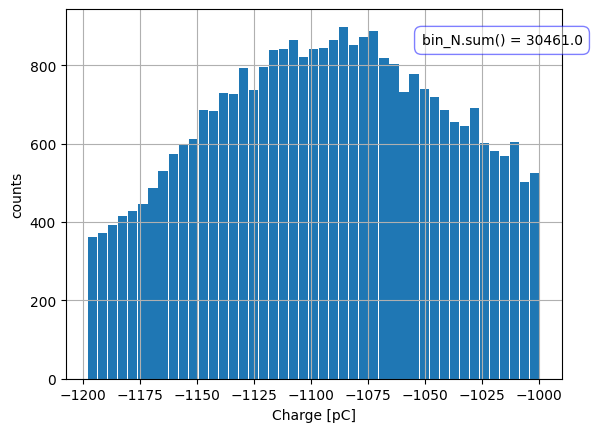

In [255]:
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))
plt.bar(centers_N, bin_N, width = 4)
#plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

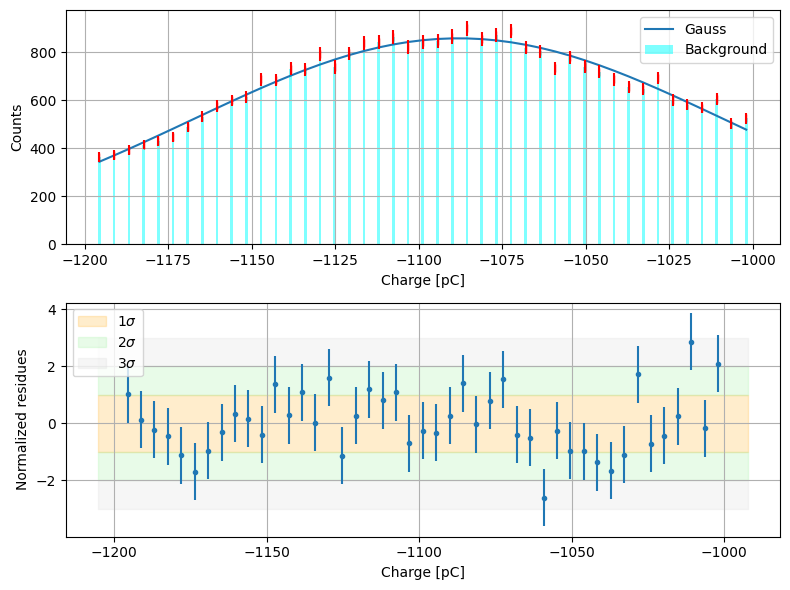

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 45
    # variables        = 3
    chi-square         = 54.1629963
    reduced chi-square = 1.28959515
    Akaike info crit   = 14.3400957
    Bayesian info crit = 19.7600831
    R-squared          = 0.96614287
[[Variables]]
    g3_amplitude:  170916.889 +/- 1939.02351 (1.13%) (init = 95515.2)
    g3_center:    -1088.07980 +/- 0.84809180 (0.08%) (init = -1087.8)
    g3_sigma:      79.5176462 +/- 1.23794905 (1.56%) (init = 59.4)
    g3_fwhm:       187.249744 +/- 2.91514719 (1.56%) == '2.3548200*g3_sigma'
    g3_height:     857.494908 +/- 7.80687567 (0.91%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.8158
    C(g3_amplitude, g3_center) = +0.3309
    C(g3_center, g3_sigma)     = +0.3247


In [256]:



sist_lims = lim_N
sist_bin = bin_N
sist_cntr = centers_N
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

In [ ]:
canale=[0,1,2,3,4,5,8,9,12,13,14,15]
#l'ultimo è il 15
carica_gamma=[-492.991122,-869.542194, -755.683667, -1125.16284, -1223.87088, -1268.36734, -879.024502, -440.515158, -706.002694,
              -734.448274, -1088.07980, -1595.94856]
sigma_gamma=[55.3238139,60.6593683, 68.7226953, 89.3657356,  82.0439831, 97.4454060,  131.835623, 34.3645975, 122.979607,
             72.0804643, 79.5176462 ,95.8597859]